## Comparisons of experiments results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
from random import randrange
%matplotlib inline

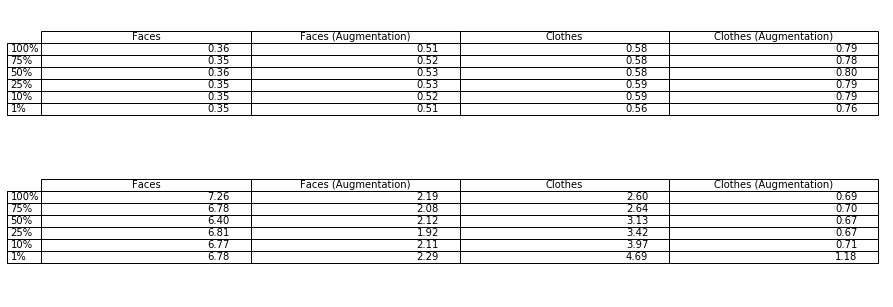

In [5]:
def load_results(file_name):
    r = np.genfromtxt(file_name, str)
    
    df = pd.DataFrame(r)
    df2 = df.loc[df[0] == "faces"]
    df3 = df2.loc[df2[2] == "False"]
    acc = df3.values[:,3].reshape((-1, 1))
    err = df3.values[:,4].reshape((-1, 1))
    
    df2 = df.loc[df[0] == "faces"]
    df3 = df2.loc[df2[2] == "True"]
    acc = np.hstack((acc, df3.values[:,3].reshape((-1, 1))))
    err = np.hstack((err, df3.values[:,4].reshape((-1, 1))))
    
    df2 = df.loc[df[0] == "clothes"]
    df3 = df2.loc[df2[2] == "False"]
    acc = np.hstack((acc, df3.values[:,3].reshape((-1, 1))))
    err = np.hstack((err, df3.values[:,4].reshape((-1, 1))))
    
    df2 = df.loc[df[0] == "clothes"]
    df3 = df2.loc[df2[2] == "True"]
    acc = np.hstack((acc, df3.values[:,3].reshape((-1, 1)))).astype(float)
    err = np.hstack((err, df3.values[:,4].reshape((-1, 1)))).astype(float)
    
    acc2 = [['%.2f' % j for j in i] for i in acc]
    err2 = [['%.2f' % j for j in i] for i in err]

    col_labels = ["Faces", "Faces (Augmentation)", "Clothes", "Clothes (Augmentation)"]
    row_labels = ["100%", "75%", "50%", "25%", "10%", "1%"]
    
    fig, ax = plt.subplots(2,1, figsize=(15, 5))
    ax[0].table(cellText=acc2, colLabels=col_labels, rowLabels=row_labels,loc='center', fontsize=14)
    ax[0].axis("off")
    
    ax[1].table(cellText=err2, colLabels=col_labels, rowLabels=row_labels,loc='center', fontsize=14)
    ax[1].axis("off")
    
#     plt.show()
    im_name = file_name.split(".")[0] + ".png"
    plt.savefig(im_name, dpi=75, bbox_inches="tight")


load_results("exp_sebastian.txt")
#load_results("exp_jonathon.txt")

# Examples of data 

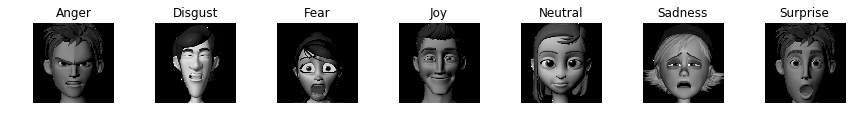

In [92]:
def show_original_expressions():
    
    file_names = []
    for folder_character in glob.glob("../data/FERG_DB_256/*"):
        for folder_expression in sorted(glob.glob(folder_character + "/*")):
            for expression in glob.glob(folder_expression + "/*"):
                file_names.append(expression)
                break
                
    file_names = np.array(file_names).astype(str).reshape((6,7))
    file_names = np.vstack((file_names, file_names[0,:]))
    file_names = file_names.diagonal()
    
    fig, ax = plt.subplots(1, 7, figsize=(12,12))
    fig.tight_layout()
    
    expressions = np.array(["Anger", "Disgust", "Fear", "Joy", "Neutral", "Sadness", "Surprise"])
    for i, name in enumerate(file_names):
        image = cv2.imread(name, cv2.IMREAD_GRAYSCALE) 
        ax[i].imshow(image, cmap="gray")
        ax[i].axis("off")
        ax[i].set_title(expressions[i])
        
    plt.savefig("original_expressions.png", dpi=75, bbox_inches="tight")
            
show_original_expressions()

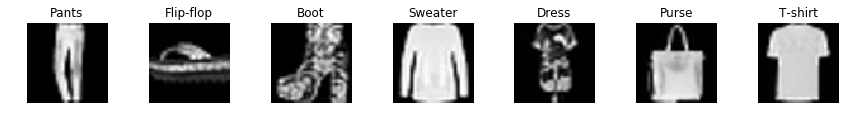

In [93]:
def show_original_clothes():
    file_names = []
    for folder_clothes in glob.glob("../data/clothes/train/*"):
        
        for cloth in glob.glob(folder_clothes + "/*"):
            file_names.append(cloth)
            break
    
    file_names = np.array(file_names).astype(str)
    
    fig, ax = plt.subplots(1, 7, figsize=(12,12))
    fig.tight_layout()
    
    expressions = np.array(["Pants", "Flip-flop", "Boot", "Sweater", "Dress", "Purse", "T-shirt"])
    for i, name in enumerate(file_names):
        image = cv2.imread(name, cv2.IMREAD_GRAYSCALE) 
        ax[i].imshow(image, cmap="gray")
        ax[i].axis("off")
        ax[i].set_title(expressions[i])
    
    plt.savefig("original_clothes.png", dpi=75, bbox_inches="tight")

show_original_clothes()

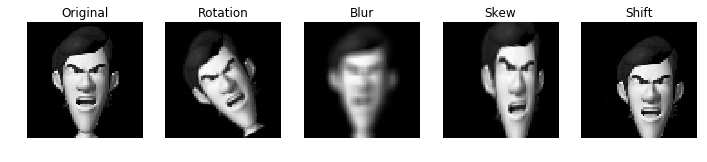

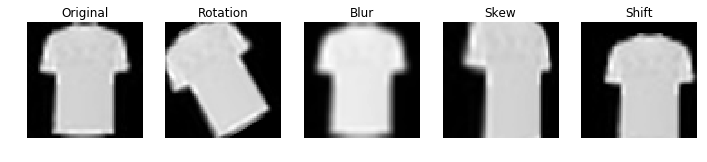

In [112]:
def rotate(image, angle=45):
    h, w = image.shape
    cx = randrange((int)(0.375 * w), (int)(0.625 * w))
    cy = randrange((int)(0.375 * h), (int)(0.625 * h))

    matrix = cv2.getRotationMatrix2D((cx, cy), angle, 1)

    image = cv2.warpAffine(image, matrix, (w,h))

    return image

def skew(image, side=0, percentage=25, reverse=False):
    h, w = image.shape

    # side 0, 1, 2, 3
    # top, bottom, left, right
    if side == 0 or side == 1:
        side_length = w
    else:
        side_length = h
    
    # remove this amount of side in the beggining and the end
    sd = (int)(side_length * percentage / 100 / 2)

    if side == 0:
        pts1 = np.float32([[sd,0],[w-1-sd,0],[0,h-1],[w-1,h-1]])
    elif side == 1:
        pts1 = np.float32([[0,0],[w-1,0],[sd,h-1],[w-1-sd,h-1]])
    elif side == 2:
        pts1 = np.float32([[0,sd],[w-1,0],[0,h-1-sd],[w-1,h-1]])
    elif side == 3:
        pts1 = np.float32([[0,0],[w-1,sd],[0,h-1],[w-1,h-1-sd]])

    pts2 = np.float32([[0,0],[w-1, 0],[0, h-1],[w-1, h-1]])

    if reverse:
        m = cv2.getPerspectiveTransform(pts2, pts1)
    else:
        m = cv2.getPerspectiveTransform(pts1, pts2)

    return cv2.warpPerspective(image, m, (w,h))

def shift(image, percentage=20, negative=False):
    h,w = image.shape

    y = (int)(h*percentage/100)
    x = (int)(w*percentage/100)

    if negative:
        x = x*-1
        y = y*-1

    m = np.float32([[1,0,x],[0,1,y]])

    return cv2.warpAffine(image, m, (w,h))

def blur(image, kernel):
    return cv2.blur(image, kernel)
    
def show_augmentations_clothes():
    for cloth in glob.glob("../data/clothes/train/0/*"):
        c = cv2.imread(cloth, cv2.IMREAD_GRAYSCALE)
        break
        
    rot = rotate(c,30)
    blu = blur(c, (5,5))
    ske = skew(c, 2, 45, 0)
    shi = shift(c, 10)
    
    fig, ax = plt.subplots(1, 5, figsize=(12,12))
    
    trans = ["Original", "Rotation", "Blur", "Skew", "Shift"]
    for i, image in enumerate([c, rot, blu, ske, shi]):
        ax[i].imshow(image, cmap="gray")
        ax[i].axis("off")
        ax[i].set_title(trans[i])
      
    plt.savefig("augmented_clothes.png", dpi=75, bbox_inches="tight")

def show_augmentations_expressions():
    for cloth in glob.glob("../data/faces/train/0/*"):
        c = cv2.imread(cloth, cv2.IMREAD_GRAYSCALE)
        break
        
    rot = rotate(c,30)
    blu = blur(c, (5,5))
    ske = skew(c, 2, 45, 0)
    shi = shift(c, 10)
    
    fig, ax = plt.subplots(1, 5, figsize=(12,12))
    
    trans = ["Original", "Rotation", "Blur", "Skew", "Shift"]
    for i, image in enumerate([c, rot, blu, ske, shi]):
        ax[i].imshow(image, cmap="gray")
        ax[i].axis("off")
        ax[i].set_title(trans[i])
      
    plt.savefig("augmented_expressions.png", dpi=75, bbox_inches="tight")

show_augmentations_expressions()      
show_augmentations_clothes()      
    
    